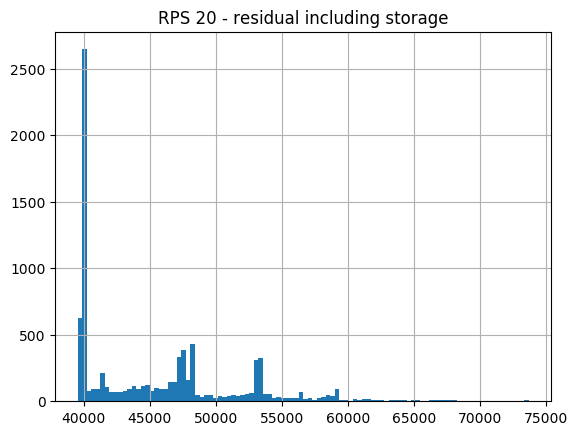

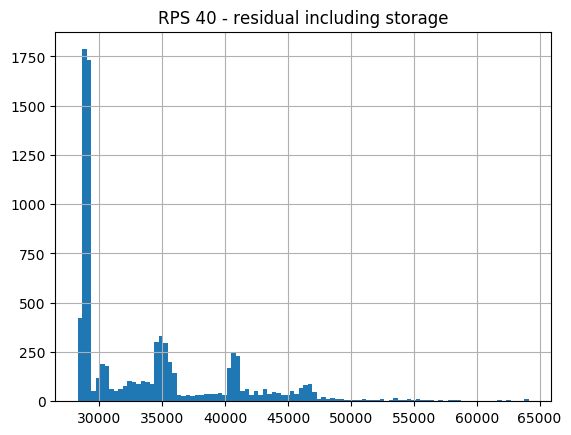

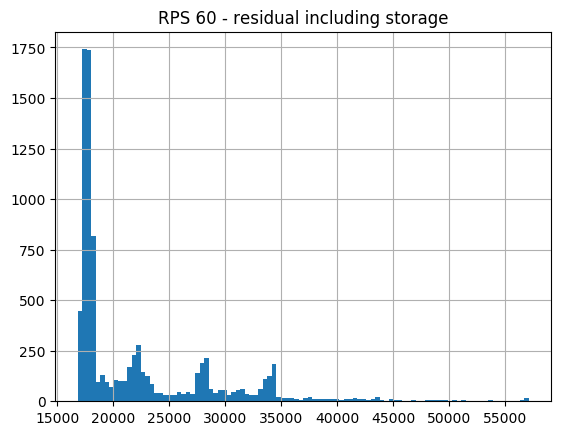

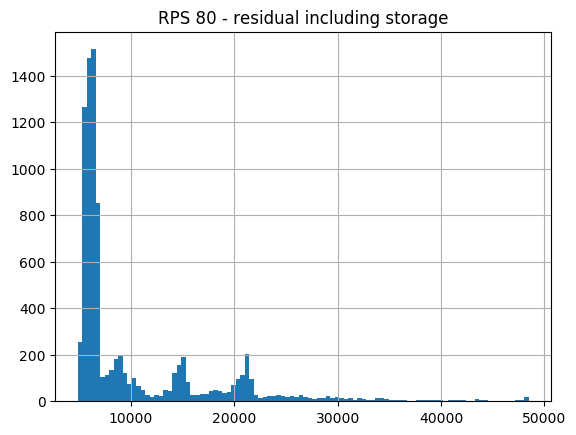

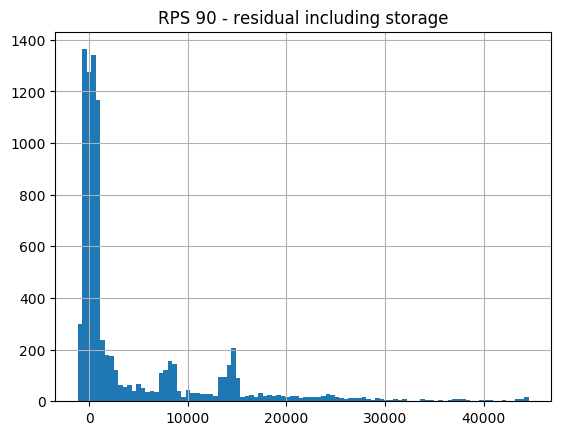

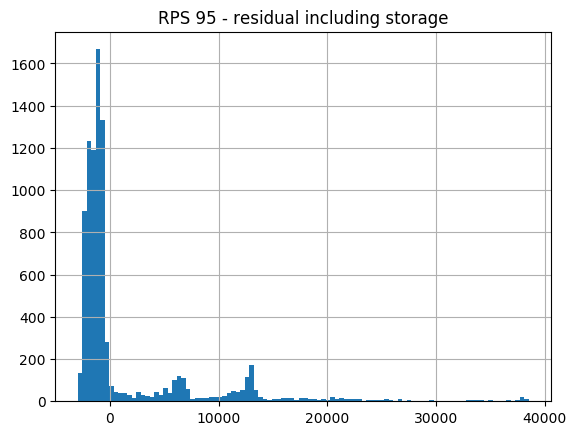

In [20]:
import os
import sys
topFolder = os.getcwd().split('\\').pop(-1)
moduleDirectory = os.getcwd()[:-len(topFolder)]
sys.path.append(moduleDirectory)

from reporting import *
%matplotlib inline
import matplotlib.pyplot as plt

path = r'C:\Users\ucqba01\Documents\Local Data\Round 6'
dbGeneric = 'hR_m_2002_waves(waves)_RPS(rps)_fcost(fcost)_newfuelcost.db'

def makedbName(dbgeneric,labelDict):
    dbstring = dbgeneric
    for param in labelDict.keys():
        dbstring = dbstring.replace(param,str(labelDict[param]))
    return dbstring

testdb = makedbName(dbGeneric,{'(rps)':'90','(waves)':'10000','(fcost)':'120'})
vrelist = ['Solar','Windonshore','Windoffshore_Shallow','Windoffshore_Mid','Windoffshore_Floating']

fcost=[100]#[80,100,120,140]
waves=[10000]#[400,10000]
RPS = [20,40,60,80,90,95]
columnList = ['vre_total','residual_load_vre','residual_incStorage']
paramsList = ['fcost','waves','rps','metric']

metrics = ['mean','std','min','max','50%']
sns.reset_defaults()
statisticalValues = pd.DataFrame(columns=paramsList+columnList,index=np.arange(len(fcost)*len(waves)*len(RPS)*len(metrics)))

i=0
for fc in fcost:
    for w in waves:
        for rps in RPS:
            db = makedbName(dbGeneric,{'(rps)':str(rps),'(waves)':str(w),'(fcost)':str(fc)})
            con = sq.connect(path+'\\'+db)
            gen_sum_h = mergeGEN('var_vre_gen_sum_h','var_non_vre_gen_sum_h',con).set_index('h').pivot(columns='gen').xs('value',axis=1,drop_level=True)
            gen_sum_h['vre_total'] = gen_sum_h[vrelist].sum(axis=1)
            demand = get('demand',con).set_index('h').pivot(columns='z').sum(axis=1)
            gen_sum_h['demand'] = demand
            
            sto = mergestore(con)
            sto_piv = sto.pivot_table(values='value',columns='s',index='h',aggfunc='sum').sum(axis=1).rename(index='storage_gen')
            gen_sum_h['storage_gen'] = sto_piv
            
            gen_sum_h['residual_load_vre'] = gen_sum_h['demand']-gen_sum_h['vre_total']
            gen_sum_h['residual_incStorage'] = gen_sum_h['demand']-gen_sum_h['vre_total']-gen_sum_h['storage_gen']
            gen_sum_h.hist(column='residual_incStorage',bins=100)
            plt.title('RPS %s - residual including storage'%rps)
            plt.show()
            
            data = gen_sum_h.describe()
            for met in metrics:
                metData = data.loc[met][columnList]
                paramseries = pd.Series(index=paramsList,data=[fc,w,rps,met])
                statisticalValues.loc[i]=paramseries.append(metData)
                i=i+1
            #print(statisticalValues)


In [23]:
statisticalValues.loc[:,['vre_total','residual_load_vre','residual_incStorage']] *= 0.001
statisticalValues

,fcost,waves,rps,metric,vre_total,residual_load_vre,residual_incStorage
0,100,10000,20,mean,12.3879,45.0824,45.668
1,100,10000,20,std,5.76901,10.5498,6.42988
2,100,10000,20,min,0.0392887,28.6715,39.5617
3,100,10000,20,max,26.263,84.5602,73.6531
4,100,10000,20,50%,12.0163,44.4044,44.0879
5,100,10000,40,mean,24.1522,33.3181,33.9067
6,100,10000,40,std,8.27916,10.5478,6.44249
7,100,10000,40,min,2.50572,16.0359,28.2771
8,100,10000,40,max,43.7549,75.074,64.1254
9,100,10000,40,50%,24.085,32.077,30.5959


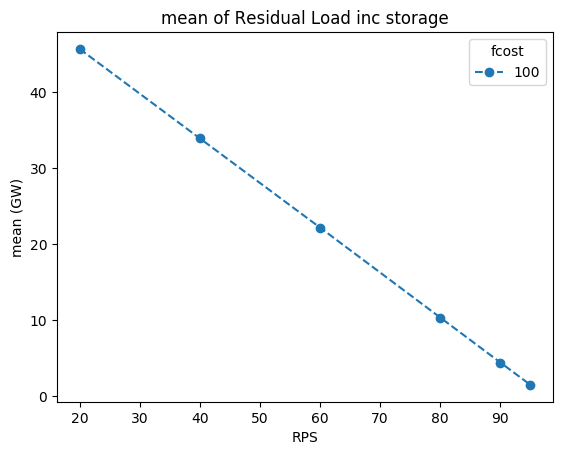

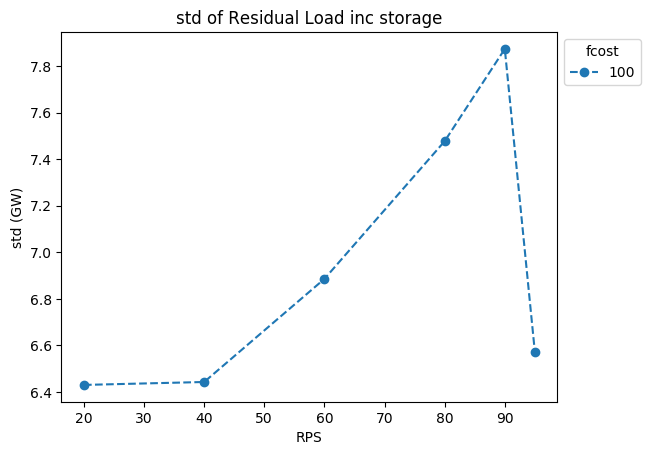

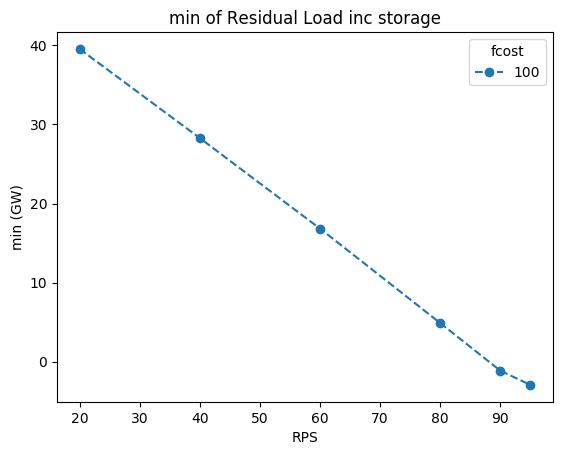

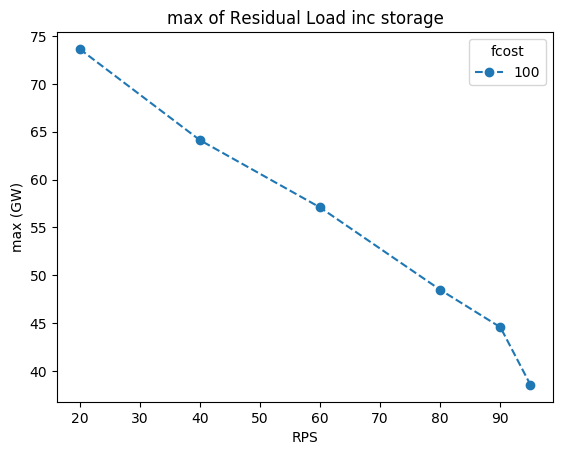

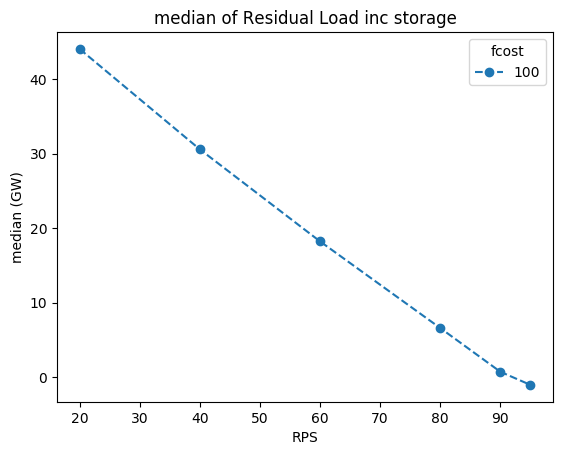

residual loads include storage


In [24]:
columnList='residual_incStorage'
for m in metrics:
    #sns.set_palette(sns.hls_palette(8,l=0.4,s=0.9))
    sns.reset_defaults()
    plotdf = statisticalValues[(statisticalValues['metric']==m) & (statisticalValues['waves']==10000)].set_index('rps').pivot(columns='fcost')[columnList]
    if m == '50%':
        m='median'
    plotdf.plot(title = '%s of Residual Load inc storage'%m,linestyle='--',marker='o').legend(title = 'fcost',bbox_to_anchor=(1,1))
    plt.ylim(ymin=0)
    plt.xlabel('RPS')
    plt.ylabel('%s (GW)'%m)
    plt.autoscale()
    outFile = r'C:\Users\ucqba01\Google Drive\Extended Research\Writing\Images\%s_residuals.png'%m
    plt.savefig(outFile,dpi=900,bbox_inches='tight')
    plt.show()
    
print('residual loads include storage')